In [16]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections
from matplotlib import cm
from matplotlib import patches

from stompy import utils, memoize, filters,xr_utils, xr_transect
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.model.fish_ptm import ptm_tools

from stompy.spatial import field, proj_utils, wkb2shp
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
# dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")
dem=field.GdalGrid("../../bathy/junction-composite-20200604-w_smooth.tif")

Velocity overview figure
---

In [3]:
adcp_transects=wkb2shp.shp2geom("../../gis/model_transects.shp")

trans=[t['name'].startswith('2018') for t in adcp_transects]

sel_adcp_transects=adcp_transects[trans]

In [4]:
def trim_seg(seg,max_l=20.):
    seg_d=utils.dist_along(seg)
    seg_trim=seg[ seg_d<max_l]
    if np.any(seg_d>max_l):
        end_x = np.interp(max_l, seg_d, seg[:,0])
        end_y = np.interp(max_l, seg_d, seg[:,1])
        seg_trim=np.vstack([ seg_trim, [end_x,end_y]] )
    return seg_trim


In [5]:
# zoom=(647100., 647456., 4185649., 4185974.)
zoom=(647066, 647547., 4185592., 4185997.)
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])
light_gray=scmap.cmap_clip(cm.gray_r,0.05,0.4)

cmap=turbo
#cmap=cm.plasma_r

pb=ptm_tools.PtmBin('../ptm/streamline_fig/global_bin.out')

_,b0=pb.read_timestep(0)
N=b0['id'].max()

#Nt=pb.count_timesteps()
Nt=20
trajs=np.zeros( (Nt,N,3),np.float64 )
for t in range(Nt):
    tstamp,locs=pb.read_timestep(t)
    trajs[t,locs['id']-1,:] = locs['x']


dt_s=1.0
t_s=np.arange(Nt)*dt_s

dry=np.all( trajs[0]==trajs[-1],axis=1)

wet_trajs=trajs[:,~dry,:2]
wet_trajs[ wet_trajs==0]=np.nan
segs=wet_trajs.transpose(1,0,2) # particle,time,{x,y}

# Select segments with unique starting x,y points
starts={}

for i in range(len(segs)):
    seg=segs[i,:,:2]
    k=(seg[0,0],seg[0,1])
    if k in starts: continue
    starts[k]=i
print("%d of %d segments unique"%(len(starts),len(segs)))
sel=np.array(list(starts.values()))
segs=segs[sel]


if 0:
    dx=utils.mag(np.diff(segs,axis=1))
    s=np.nanmean(dx/dt_s,axis=1)
    segs=[seg for seg in segs]
else:
    trim_segs=[]
    speeds=[]
    max_l=7.0 
    for seg in segs:       
        seg_d=utils.dist_along(seg)
        trim_seg=seg[ seg_d<max_l]
        if np.any(seg_d>=max_l):
            # print("Trimmed")
            end_x = np.interp(max_l, seg_d, seg[:,0])
            end_y = np.interp(max_l, seg_d, seg[:,1])
            end_t = np.interp(max_l, seg_d, t_s)
            trim_seg=np.vstack([ trim_seg, [end_x,end_y]] )
            speed=max_l/end_t
        else:
            speed=seg_d[-1]/t_s[-1]
        trim_segs.append(trim_seg)
        speeds.append(speed)
    segs=trim_segs
    s=np.array(speeds)

1379 of 45303 segments unique


/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal


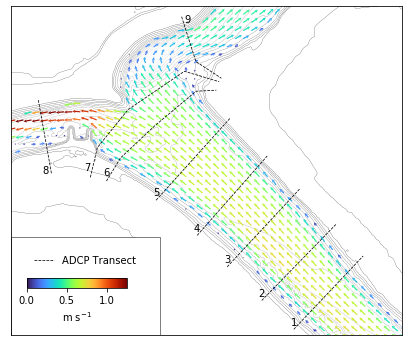

In [6]:
valid=np.isfinite(s)
segs=[seg for seg,val in zip(segs,valid) if val]
speeds=s[valid]
clim=[0.0,1.25]
lcoll=collections.LineCollection(segs,
                                 array=speeds, clim=clim,cmap=cmap,
                                 lw=1.2)
fig,ax=plt.subplots(1,1,figsize=[5.55, 4.66])

ax.add_collection(lcoll)

if 1:
    dV=1.0
    #demc.contourf(np.arange(-6,6,dV),
    #              ax=ax,
    #              cmap=light_gray,
    #              extend='both',
    #              zorder=-2)
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
    
ax.axis('equal')
ax.axis(zoom)
ax.yaxis.set_visible(0)
ax.xaxis.set_visible(0)

ax.set_position([0.01,0.01,0.98,0.98])
cax=fig.add_axes([0.05,0.15,0.25,0.03])
plt.colorbar(lcoll,cax=cax,label='m s$^{-1}$',orientation='horizontal')
#ax.patch.set_facecolor('#9c9c9c')

# And quiver to put a head on it.
# Need end points, end velocity for each segments
xyuvs=[]
for speed,seg in zip(speeds,segs):
    seg=seg[np.isfinite(seg[:,0])]
    uv=speed*utils.to_unit(seg[-1]-seg[-2])
    xyuvs.append( [seg[-1,0],seg[-1,1],uv[0],uv[1]])
xyuvs=np.array(xyuvs)

if 0: 
    scale=0.5
    ax.quiver(xyuvs[:,0],xyuvs[:,1],xyuvs[:,2],xyuvs[:,3],speeds,cmap=cmap,
              clim=clim,units='x',angles='xy',scale_units='xy',scale=scale,
              minlength=0.001,
              headaxislength=150,headwidth=100,headlength=200)
else:
    # manual arrow heads.
    angles=np.arctan2(xyuvs[:,3],xyuvs[:,2])

    sym=2.0 * np.array( [ [1.5,    0],
                    [-0.5, 1],
                    [0,    0],
                    [-0.5, -1]])
    diam=np.array([ [0.5,0],
                    [0, 0.5],
                    [-0.5,0],
                   [0,-0.5]])


    polys=[ utils.rot(angles[i],sym) for i in range(len(xyuvs))]
    polys=np.array(polys)
    polys[speeds<0.1,:]=diam
    polys += xyuvs[:,None,:2]

    pcoll=collections.PolyCollection(polys)
    pcoll.set_array(speeds)
    pcoll.set_cmap(cmap)
    pcoll.set_clim(clim)
    ax.add_collection(pcoll)

# And show the ADCP transect locations, too.
for t in sel_adcp_transects:
    name=int(t['name'].replace('2018_',''))
    xy=np.array(t['geom'])
    l=ax.plot(xy[:,0],xy[:,1],color='k',ls='--',lw=0.75)
    plot_utils.annotate_line(l[0],name,ax=ax,norm_position=0.05,rotation=None,
                            offset_points=5)

ax.legend([l[0]],["ADCP Transect"],
         loc=[0.05,0.2],frameon=0)
from matplotlib import patches
ax.add_patch( patches.Rectangle([0,0],0.38,0.3,transform=ax.transAxes,fc='w',ec='k',lw=0.5 ))

# Debugging:
#ax.axis( (647197.183614895, 647267.2260859122, 4185895.635289999, 4185954.610759359) )
#fig.savefig('velo-2d-map.png',dpi=200)

Streamline Tracer Approach
--

In [7]:
# This still sort of sucks.
# Go back to real data:
# model=sun_driver.SuntansModel.load('runs/short045_g8.24_20180405')
# What a pain.. avg_nc has cell-center velocities already calculated,
# while ptm_avg has volumes already calculated.
avg_nc=xr.open_dataset('runs/short045_g8.24_20180405/average.nc_0000.nc')
ptm_avg_nc=xr.open_dataset('runs/short045_g8.24_20180405/ptm_average.nc_0000.nc')

t_idx=len(ptm_avg_nc.Mesh2_data_time)-1 
avg_snap=avg_nc.isel(time=t_idx)
ptm_snap=ptm_avg_nc.isel(nMesh2_data_time=t_idx)

assert np.all( avg_snap.time.values == ptm_snap.Mesh2_data_time.values)

In [8]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(avg_snap)
c2e=g.cells['edges']
c2e[ c2e==999999 ] = -1

In [9]:
# Depth-average cell center velocities
vol=ptm_snap.Mesh2_face_water_volume.values[:,::-1]
U=avg_snap.uc.values.T
V=avg_snap.vc.values.T

In [92]:
Udavg=np.nansum(U*vol,axis=1) / np.nansum(vol,axis=1)
Vdavg=np.nansum(V*vol,axis=1) / np.nansum(vol,axis=1)
# Could get stream_tracer to do the perot calc.
Uc=np.c_[ Udavg, Vdavg]

mag_davg=utils.mag(Uc)

/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(646848.34449, 648043.88685, 4185468.6746, 4186172.4437)

/home/rusty/miniconda3/envs/general/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


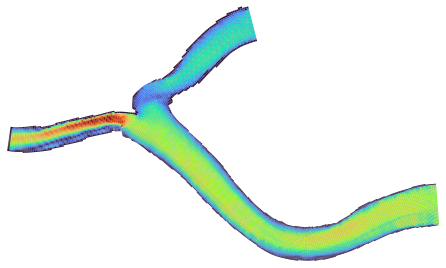

In [11]:
fig,ax=plt.subplots()
g.plot_edges(color='k',lw=0.3,alpha=0.2)
g.plot_cells(values=mag_davg,clim=[0,1.5],cmap=turbo)
ax.set_position([0,0,1,1])
ax.axis('off')

In [12]:
from shapely import geometry
bounds=g.bounds()
# Select a starting point for a trace:
boundary=g.boundary_polygon()

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=153556.213484, 0 potential interiors


In [76]:
from stompy.grid import exact_delaunay
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(exact_delaunay)

<module 'stompy.grid.exact_delaunay' from '/home/rusty/src/stompy/stompy/grid/exact_delaunay.py'>

In [77]:
def init_tri():
    tri=exact_delaunay.Triangulation()
    tri.add_cell_field('outside',np.zeros(0,np.bool8))
    tri.add_node_field('tip',np.zeros(0,np.bool8))
    tri.cell_defaults['_center']=np.nan
    tri.cell_defaults['_area']=np.nan
    tri.cell_defaults['outside']=False
    tri.node_defaults['tip']=False
    
    bound_cycle=g.boundary_cycle()
    tri.bulk_init( g.nodes['x'][bound_cycle] )

    for a,b in utils.circular_pairs(np.arange(len(bound_cycle))):
        tri.add_constraint(a,b)

    tri.cells['_area']=np.nan
    centers=tri.cells_centroid()
    for c in tri.valid_cell_iter():
        if not boundary.intersects(geometry.Point(centers[c])):
            tri.cells['outside'][c]=True
        else:
            tri.cells['outside'][c]=False
    return tri

In [78]:
def constrained_centers(self):
    ccs=self.cells_center(refresh=True) # circumcenters
    centroids=self.cells_centroid()
    e2c=self.edge_to_cells() # recalc=True)
    cell_with_constraint=np.unique( e2c[ self.edges['constrained']] )
    result=ccs.copy()
    result[cell_with_constraint] = centroids[cell_with_constraint]
    return result


In [80]:
from stompy.model import stream_tracer
six.moves.reload_module(stream_tracer)



In [101]:
len( dict(a=1,b=2))

2

In [127]:
def add_trace_to_tri(trace,min_clearance=10.0):
    """
    trace: a trace Dataset as return from stream_tracer
    """
    if 'root' in trace:
        trace_root=trace.root.item()
    else:
        trace_root=0
        
    xys=trace.x.values
    if trace.stop_condition.values[0]=='leave_domain':
        xys=xys[1:]
        trace_root=max(0,trace_root-1)
    if trace.stop_condition.values[-1]=='leave_domain':
        xys=xys[:-1]

    recent={}

    nroot=tri.add_node(x=xys[trace_root])
    recent[nroot]=True
    
    clearance=neighbor_clearance(nroot,recent)
    if clearance<min_clearance:
        print(".",end="")
        return len(recent)
    
    for incr in [1,-1]:
        xy_leg=xys[trace_root+incr::incr]
        na=nroot
        for xy in xy_leg:
            if np.all(xy==tri.nodes['x'][na]):
                # root is repeated. could happen in other cases, too.
                continue
            nb=tri.add_node(x=xy)
            recent[nb]=True
            clearance=neighbor_clearance(nb,recent)
            if clearance<min_clearance:
                # if it's too close, don't add an edge
                print("-",end="")
                break
            try:
                tri.add_constraint(na,nb)
            except tri.IntersectingConstraints:
                print('!') # shouldn't happen..
                break
            na=nb
        if incr>0:
            tri.nodes['tip'][na]=True
    return len(recent)

def pick_starting_point():
    # Pick a triangle based on largest circumradius:
    #centers=tri.cells_centroid() 
    centers=constrained_centers(tri) # .cells_center(refresh=True)

    radii=utils.dist(centers - tri.nodes['x'][tri.cells['nodes'][:,0]])
    radii[ tri.cells['outside'] | tri.cells['deleted']] = 0.0
    radii[ ~np.isfinite(radii)]=0.0
    best=np.argmax(radii)

    xy=centers[best]
    print("*",end="") # xy)

    if not boundary.intersects( geometry.Point(xy) ):
        raise Exception("Crap")
    return xy

# would have been keeping track of the recent nodes as they were 
# created.
def neighbor_clearance(n,recent={}):
    nbrs=[nbr for nbr in tri.node_to_nodes(n) if nbr not in recent]
    nbr_dists=utils.dist( tri.nodes['x'][n] - tri.nodes['x'][nbrs])
    return nbr_dists.min()

In [128]:
tri=init_tri()

In [129]:
short_traces=0

for i in range(500):
    xy=pick_starting_point()
    trace=stream_tracer.steady_streamline_twoways(g,Uc,xy,max_t=20.0)
    n_nodes=add_trace_to_tri(trace,min_clearance=8.0)
    if n_nodes==1:
        short_traces+=1
        if short_traces>50:
            break

***************************-****************************-***********************************--*********-*-************--*****-**-*--***-**-*-**-******--*-*****-*-*-*-*****-**--*--**--**-**-****--*-*-***-***-*-**-*-*-**-*.*-**--*-***-**-**--*--**.****-***--*.*--*--*-**-*-*.*-**-*-*-**--*-*-*-*-*-*--***-*--**--*--*--**-*-*--*.*-*-**-*-*-*-*--*--*-*--*--*--*--*-**-*-*.*--****-*--**-*--*-***-*-*.*--*-*-***-*-*-*--*--*-*-*--**--*--*-*--*--*-**--*-**--*-*--*-*-**--*--*-*-*--*--*--*-*--*--**--*-*--*--*-*-*-*--*-*--*--*--*--*--*--*-*-*-*--*--*--*-*-*-*--*-*--*-**-*-**--*-*--*--*--*--*--*--**--*--*.*-*--*--*-*--*--**.*--*-*--*-*-*-*--*--*--*--*--*--*--*.*-*--*--*--***-*--**--*--**-*-*-*--*--*-*--**--*--*--*-*--*.*--*.*-*--*-*-*--*-*--*--*-*--*--*--*--*--**-*-*--*--*--*-*--*-*--*-*-*--*-*.*-*--*--*--*--*--*--*--*--*-**-*.*-*--*--*-*-*-**-*--*--*--*-*-*-*-*-*-*--*--*--*--*--*-**--*--*-*-*--*-*--*-*-*--*--*--*--*-*--*--*--*--*-*--*--*--*--*--*--*--*-*--*--*--*--*--*-

<IPython.core.display.Javascript object>


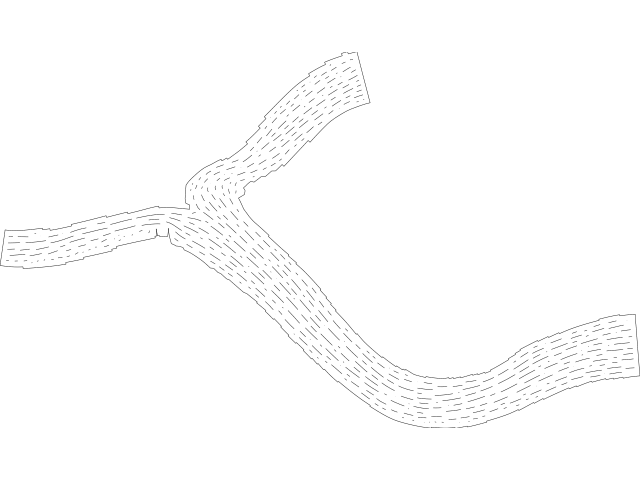

In [130]:
fig,ax=plt.subplots()
sel=~(tri.cells['outside'] | tri.cells['deleted'] )
#tri.plot_cells(mask=sel)
tri.plot_edges(color='k',lw=0.3,mask=tri.edges['constrained'])
# tri.plot_edges(color='0.7',lw=0.3,mask=~tri.edges['constrained'])
#ax.plot(centers[sel,0],centers[sel,1],'r.')
# tri.plot_nodes(mask=tri.nodes['tip'])
ax.axis('off')
ax.set_position([0,0,1,1])

In [131]:
# Extract segments starting from nodes marked as tip

strings=tri.extract_linear_strings(edge_select=tri.edges['constrained'])

# Order them ending with the tip, and only strings that include
# a tip (gets rid of boundary)
segs=[]
for string in strings:
    node_tips=tri.nodes['tip'][string]
    if np.all( ~node_tips): continue
    xy=tri.nodes['x'][string]
    if node_tips[0]:
        xy=xy[::-1]
    elif node_tips[-1]:
        pass
    else:
        print("Weird - there's a tip but it's not at the tip")
    segs.append(xy)

tip_cells=[g.select_cells_nearest(seg[-1],inside=True) for seg in segs]
speeds=mag_davg[tip_cells]`

In [155]:
#clip=ax.axis()

aerial=field.GdalGrid('../../gis/aerial/m_3712114_sw_10_h_20160621_20161004-UTM.tif',
                     geo_bounds=zoom)
aerial.F=aerial.F[:,:,:3] # drop alpha - seems mis-scaled


Putting multiple channels as last index


<IPython.core.display.Javascript object>


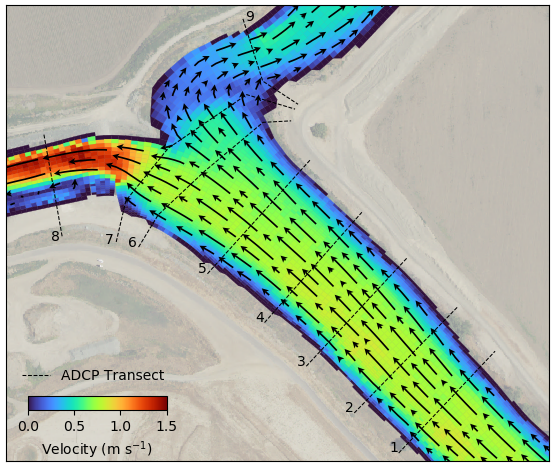

In [159]:
clim=[0.0,1.5]
lcoll=collections.LineCollection(segs,
                                 array=speeds, clim=clim,cmap=cmap,
                                 lw=1.2)
fig,ax=plt.subplots(1,1,figsize=[5.55, 4.66])

ax.add_collection(lcoll)

if 0:
    dV=1.0
    demc.contour(np.arange(-10,6,dV),ax=ax,
                 cmap='gray_r',linewidths=0.2,
                 zorder=-1)
    
ax.axis('equal')
ax.axis(zoom)
ax.yaxis.set_visible(0)
ax.xaxis.set_visible(0)

ax.set_position([0.01,0.01,0.98,0.98])
cax=fig.add_axes([0.05,0.12,0.25,0.03])
plt.colorbar(lcoll,cax=cax,label='Velocity (m s$^{-1}$)',orientation='horizontal')
#ax.patch.set_facecolor('#9c9c9c')

# And quiver to put a head on it.
# Need end points, end velocity for each segments
xyuvs=[]
for speed,seg in zip(speeds,segs):
    seg=seg[np.isfinite(seg[:,0])]
    uv=speed*utils.to_unit(seg[-1]-seg[-2])
    xyuvs.append( [seg[-1,0],seg[-1,1],uv[0],uv[1]])
xyuvs=np.array(xyuvs)

if 1: 
    # manual arrow heads.
    angles=np.arctan2(xyuvs[:,3],xyuvs[:,2])

    sym=3.0 * np.array( [ [1.5,    0],
                    [-0.5, 1],
                    [0,    0],
                    [-0.5, -1]])
    diam=np.array([ [0.5,0],
                    [0, 0.5],
                    [-0.5,0],
                   [0,-0.5]])

    polys=[ utils.rot(angles[i],sym) for i in range(len(xyuvs))]
    polys=np.array(polys)
    polys[speeds<0.1,:]=diam
    polys += xyuvs[:,None,:2]

    pcoll=collections.PolyCollection(polys)
    pcoll.set_array(speeds)
    pcoll.set_cmap(cmap)
    pcoll.set_clim(clim)
    pcoll.set_lw(0)

    ax.add_collection(pcoll)

# And show the ADCP transect locations, too.
for t in sel_adcp_transects:
    name=int(t['name'].replace('2018_',''))
    xy=np.array(t['geom'])
    l=ax.plot(xy[:,0],xy[:,1],color='k',ls='--',lw=0.75)
    plot_utils.annotate_line(l[0],name,ax=ax,norm_position=0.0,rotation=None,
                            offset_points=5)

ax.legend([l[0]],["ADCP Transect"],
         loc=[0.02,0.16],frameon=0)

# ax.add_patch( patches.Rectangle([0,0],0.38,0.25,transform=ax.transAxes,fc='w',ec='k',lw=0.5 ))

if 1: # black arrows, color in background for speed
    for coll in [lcoll,pcoll]:
        coll.set_array(None)
        coll.set_color('k')
    ccoll=g.plot_cells(values=mag_davg,cmap=cmap,clim=clim,ax=ax,zorder=-2)
    ccoll.set_edgecolor('face')
    ccoll.set_lw(0.2)

if 1: # add aerial image in backgroud
    aerial.plot(ax=ax,zorder=-3,alpha=0.5)
    
fig.savefig('velocity-overview.png',dpi=200)

Putting multiple channels as last index


In [154]:

aerial.plot(ax=ax,zorder=-3)